# CelebA

In this notebook we show the results for CelebA. You can create from scratch the features or use the pre-computed ones.

### 1. Create feature

If you want to create the features, first of all unzip file "dataset_celebA.7z ". Be sure to save the folder together with this notebook. You also need to download  [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

Otherwise, just jump to section 2.

In [1]:
import cv2
import numpy as np
import os
import radialProfile
import glob
from matplotlib import pyplot as plt
import pickle
from scipy.interpolate import griddata

data= {}
epsilon = 1e-8
N = 80
y = []
error = []

number_iter = 1000

psd1D_total = np.zeros([number_iter, N])
label_total = np.zeros([number_iter])
psd1D_org_mean = np.zeros(N)
psd1D_org_std = np.zeros(N)


cont = 0

#fake data
rootdir = 'dataset_celebA/'

for filename in glob.glob(rootdir+"*.jpg"):
    img = cv2.imread(filename,0)
    
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon
    
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)

    # Calculate the azimuthally averaged 1D power spectrum
    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')
    interpolated /= interpolated[0]

    psd1D_total[cont,:] = interpolated             
    label_total[cont] = 1
    cont+=1

    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean[x] = np.mean(psd1D_total[:,x])
    psd1D_org_std[x]= np.std(psd1D_total[:,x])
    

## real data
psd1D_total2 = np.zeros([number_iter, N])
label_total2 = np.zeros([number_iter])
psd1D_org_mean2 = np.zeros(N)
psd1D_org_std2 = np.zeros(N)

cont = 0
rootdir2 = '/home/duralllopez/DATASETS/celebA/img_align_celeba/'


for filename in glob.glob(rootdir2+"*.jpg"):     
    img = cv2.imread(filename,0)

    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    fshift += epsilon

    magnitude_spectrum = 20*np.log(np.abs(fshift))

    # Calculate the azimuthally averaged 1D power spectrum
    psd1D = radialProfile.azimuthalAverage(magnitude_spectrum)

    points = np.linspace(0,N,num=psd1D.size) # coordinates of a
    xi = np.linspace(0,N,num=N) # coordinates for interpolation

    interpolated = griddata(points,psd1D,xi,method='cubic')

    interpolated /= interpolated[0]

    psd1D_total2[cont,:] = interpolated             
    label_total2[cont] = 0
    cont+=1
    
    if cont == number_iter:
        break

for x in range(N):
    psd1D_org_mean2[x] = np.mean(psd1D_total2[:,x])
    psd1D_org_std2[x]= np.std(psd1D_total2[:,x])
    

y.append(psd1D_org_mean)
y.append(psd1D_org_mean2)
error.append(psd1D_org_std)
error.append(psd1D_org_std2)

psd1D_total_final = np.concatenate((psd1D_total,psd1D_total2), axis=0)
label_total_final = np.concatenate((label_total,label_total2), axis=0)

data["data"] = psd1D_total_final
data["label"] = label_total_final

output = open('celeba_low_1000.pkl', 'wb')
pickle.dump(data, output)
output.close()

print("DATA Saved") 

DATA Saved


### 2. Loading Features

Now, we load the features. Either the pre-computed ones or the features that you have created.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

# load feature file
pkl_file = open('celeba_low_1000.pkl', 'rb')
data = pickle.load(pkl_file)
pkl_file.close()
X = data["data"]
y = data["label"]

We look at the label distribution, to be sure that we have a balanced dataset.

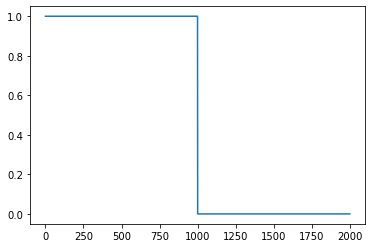

In [4]:
plt.plot(y)

### 3. Check Spectrum

We have a look to the spectrum

Text(0, 0.5, 'Power Spectrum')

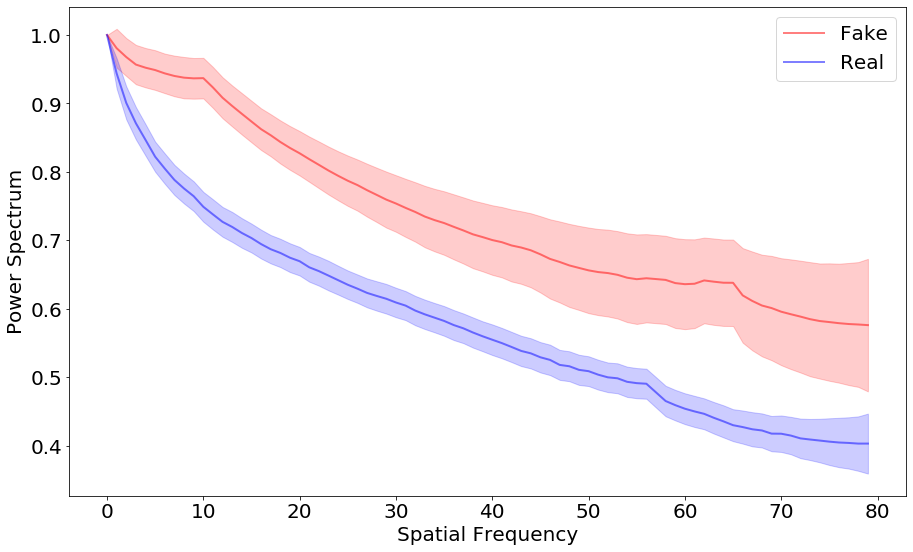

In [5]:
num = int(X.shape[0]/2)
num_feat = X.shape[1]

psd1D_org_0 = np.zeros((num,num_feat))
psd1D_org_1 = np.zeros((num,num_feat))
psd1D_org_0_mean = np.zeros(num_feat)
psd1D_org_0_std = np.zeros(num_feat)
psd1D_org_1_mean = np.zeros(num_feat)
psd1D_org_1_std = np.zeros(num_feat)

cont_0=0
cont_1=0

# We separate real and fake using the label
for x in range(X.shape[0]):
    if y[x]==0:
        psd1D_org_0[cont_0,:] = X[x,:]
        cont_0+=1
    elif y[x]==1:
        psd1D_org_1[cont_1,:] = X[x,:]
        cont_1+=1

# We compute statistcis
for x in range(num_feat):
    psd1D_org_0_mean[x] = np.mean(psd1D_org_0[:,x])
    psd1D_org_0_std[x]= np.std(psd1D_org_0[:,x])
    psd1D_org_1_mean[x] = np.mean(psd1D_org_1[:,x])
    psd1D_org_1_std[x]= np.std(psd1D_org_1[:,x])
    
# Plot
x = np.arange(0, num_feat, 1)
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(x, psd1D_org_0_mean, alpha=0.5, color='red', label='Fake', linewidth =2.0)
ax.fill_between(x, psd1D_org_0_mean - psd1D_org_0_std, psd1D_org_0_mean + psd1D_org_0_std, color='red', alpha=0.2)
ax.plot(x, psd1D_org_1_mean, alpha=0.5, color='blue', label='Real', linewidth =2.0)
ax.fill_between(x, psd1D_org_1_mean - psd1D_org_1_std, psd1D_org_1_mean + psd1D_org_1_std, color='blue', alpha=0.2)

plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20})
plt.xlabel("Spatial Frequency", fontsize=20)
plt.ylabel("Power Spectrum", fontsize=20)
#plt.savefig('1000_celeba.png', bbox_inches='tight')

### 4. Classification

Now we classify using the features.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

num = 10
LR = 0
SVM = 0
SVM_r = 0
SVM_p = 0


for z in range(num):
    # read python dict back from the file
    pkl_file = open('celeba_low_1000.pkl', 'rb')
    
    data = pickle.load(pkl_file)

    pkl_file.close()
    X = data["data"]
    y = data["label"]


    try:

        from sklearn.model_selection import train_test_split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

        from sklearn.svm import SVC
        svclassifier = SVC(kernel='linear')
        svclassifier.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier.score(X_test, y_test)))
               
        from sklearn.svm import SVC
        svclassifier_r = SVC(C=6.37, kernel='rbf', gamma=0.86)
        svclassifier_r.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier_r.score(X_test, y_test)))
                
        from sklearn.svm import SVC
        svclassifier_p = SVC(kernel='poly')
        svclassifier_p.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(svclassifier_p.score(X_test, y_test)))
        
        from sklearn.linear_model import LogisticRegression
        logreg = LogisticRegression(solver='liblinear', max_iter=1000)
        logreg.fit(X_train, y_train)
        #print('Accuracy on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

        
        SVM+=svclassifier.score(X_test, y_test)
        SVM_r+=svclassifier_r.score(X_test, y_test)
        SVM_p+=svclassifier_p.score(X_test, y_test)
        LR+=logreg.score(X_test, y_test)

        
    except:
        num-=1
        print(num)
    
print("Average SVM: "+str(SVM/num))
print("Average SVM_r: "+str(SVM_r/num))
print("Average SVM_p: "+str(SVM_p/num))
print("Average LR: "+str(LR/num))

/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarni

Average SVM: 0.9995
Average SVM_r: 1.0
Average SVM_p: 0.9855
Average LR: 0.9975000000000002


/opt/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
